In [1]:
## Setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = [14, 4]

## Exploratory Data Analysis

The dataset weather-data.csv is obtained from [IOWA Environmental Mesonet - Iowa State University](https://mesonet.agron.iastate.edu/)

Columns for this dataset:

+ station: Acronym for the place of data capture.
+ valid: Date and time of capture.
+ tmpc: Temperature of the environment in celsius.
+ dwpc: Temperature of the dew point in the environment in celsius.
+ relh: Relative humidity of the environment in percentage.
+ sknt: Wind Speed in knots.
+ gust: Wind Gust in knots.
+ peak_wind_drct: Peak Wind Gust Direction (from PK WND METAR remark). (deg).

In [2]:
data = pd.read_csv('weather-data.csv')
data.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


At a first glance, it's easy to spot that the data is sampled at a 30-min interval, so a time series modeling can be used at a later stage.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0    station        103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


In [4]:
data['valid'] = data['valid'].astype("datetime64")
data.set_index('valid', inplace=True)

'valid' should be of datatime type and the index for the dataframe.

In [5]:
len(data[' station'].unique())

1

In [6]:
data.drop('peak_wind_drct', 1, inplace=True)
data.drop(' station', 1, inplace=True)

 peak_wind_drct' can be dropped as it has no non-null value, and 'station' can be dropped as it has a single value of 'NZAA'. Imputation should be considered at a later stage for other columns where there are some missing values (the number of non-null values is less than the record number), such as 'dwpc' (103678 < 103713). 

<AxesSubplot:>

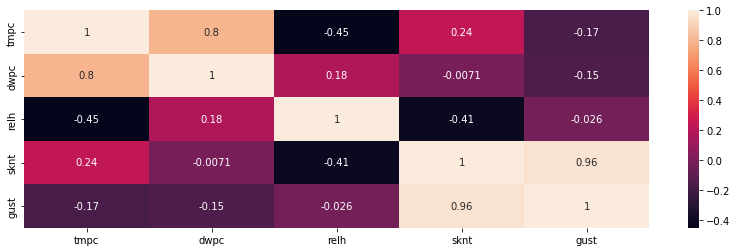

In [7]:
sns.heatmap(data.corr(), annot=True)

The dew point temperature is the temperature to which air must be cooled to become saturated with water vapor, assuming constant air pressure and water content. Therefore, it is understandably correlated with the temperature (the air needed to be cooled), relative humidity (water content) and the wind speed/gust (air pressure). Apart from that, the correlation between the wind speed and the wind gust is quite noticable.

In [8]:
data.describe()

,tmpc,dwpc,relh,sknt,gust
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000
mean,15.811503,12.115772,79.782307,8.919029,30.962594
std,4.235197,3.738005,12.562199,5.348379,6.319510
min,2.000000,-2.000000,29.230000,0.000000,13.000000
25%,13.000000,9.000000,71.450000,5.000000,27.000000
50%,16.000000,12.000000,81.990000,8.000000,31.000000
75%,19.000000,15.000000,88.180000,12.000000,35.000000
max,29.000000,23.000000,100.000000,42.000000,56.000000


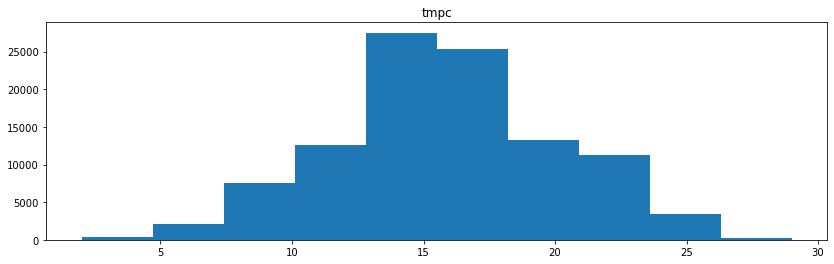

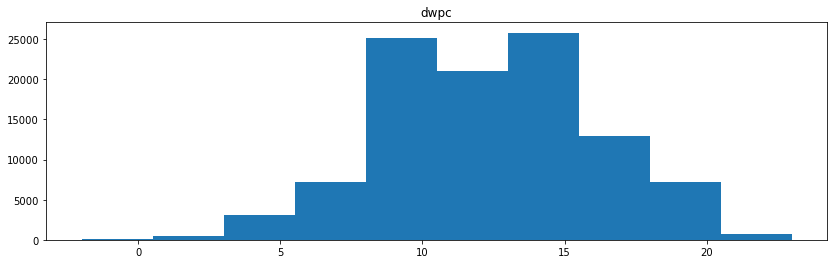

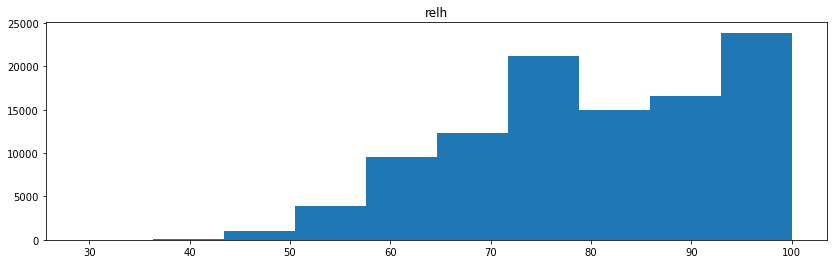

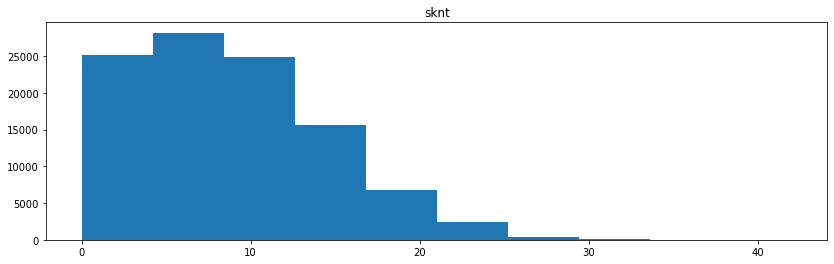

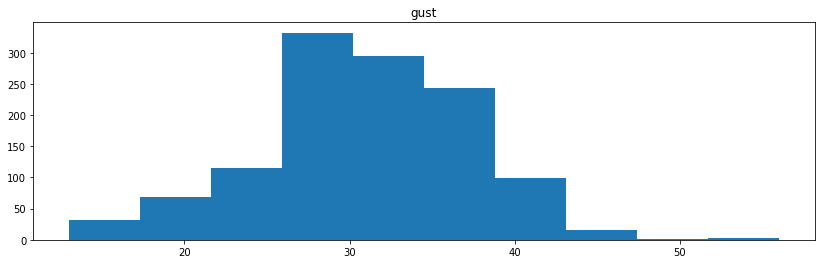

In [9]:
# distributions
for column_name in data.columns:
    plt.hist(data[column_name])
    plt.title(column_name)
    plt.show()

Since they're all numeric values, we care about distributions. Temperature and dew point temperature are approximately normally distributed, while others are skewed.

## Data Preparation

### Imputation

In [10]:
data['gust'].fillna(data['sknt'], inplace=True)

When 'gust' is nan, there's assumingly no significant change in the wind speed. -> it can be filled with the wind speed at the same time.

In [11]:
data.fillna((data.fillna(method='bfill')+data.fillna(method='ffill'))/2, inplace=True)

When other columns are nan, we assume they don't significantly change over a short period. -> they can be filled with the average of the last and the next valid observations.

### Preprocessing

#### Train and test sets

In [12]:
pd.date_range(data.index.min(), data.index.max())

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', length=2191, freq='D')

The data spanned 6 years from 2015 to 2020. 

In [13]:
train = data[:'2020-09'].resample("D").mean()
test = data['2020-10':].resample("D").mean()

We use the last 3 months to evaluate our model.

## Data Modelling

#### Visualize the Time Series

In [14]:
## helper function to create run-sequence, rolling mean and rolling standard deviation
def tsplot(column_name):
    #Determing rolling statistics
    rolmean = train[column_name].rolling(window=365).mean()
    rolstd = train[column_name].rolling(window=365).std()

    #Plot rolling statistics:
    orig = plt.plot(train[column_name], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(column_name)
    plt.grid()
    plt.show(block=False)

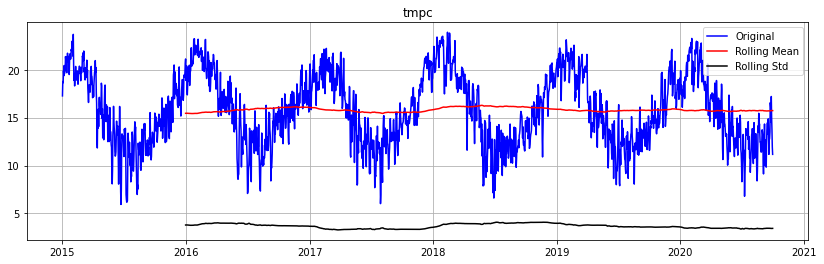

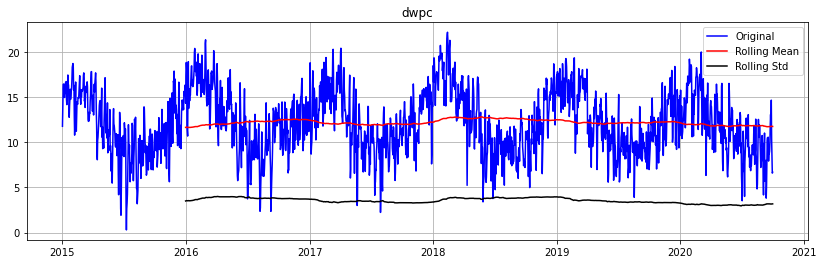

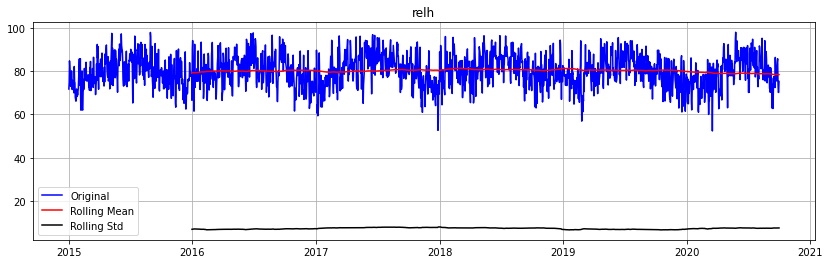

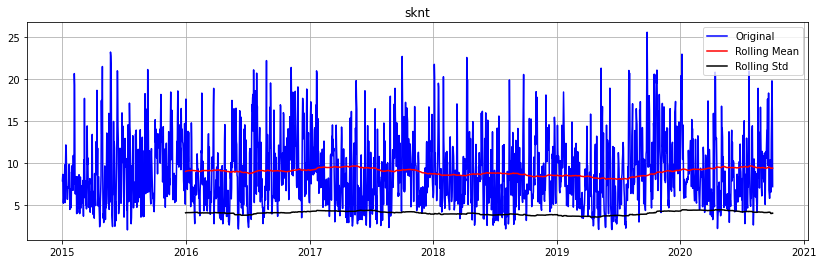

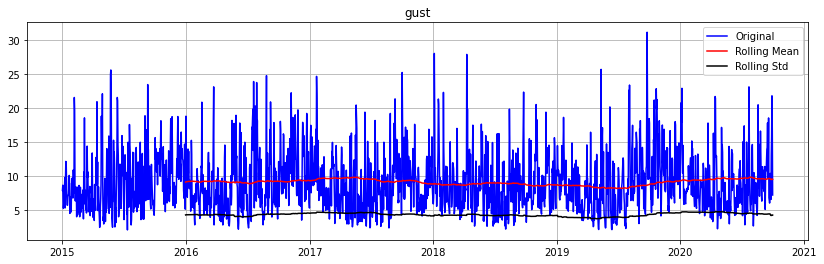

In [15]:
## plot against each column
for column_name in train.columns:
    tsplot(column_name)

We can see from the plots that all of them are approximately stationary. 

#### Stationarize the Series

In [16]:
## helper function to perform a formal Dickey-Fuller Test where the null hypothesis is that the series is not stationary
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [17]:
## test against each column
for colunm_name in train.columns:
    print("Please find the result below for %s: "%(colunm_name))
    dftest(train[[colunm_name]])
    print("\n")

Please find the result below for tmpc: 
Test Statistic            -2.812254
p-value                    0.056545
Lags Used                 15.000000
Observations Used       2084.000000
Critical Value (1%)       -3.433492
Critical Value (5%)       -2.862928
Critical Value (10%)      -2.567509
dtype: float64


Please find the result below for dwpc: 
Test Statistic            -3.418373
p-value                    0.010348
Lags Used                 19.000000
Observations Used       2080.000000
Critical Value (1%)       -3.433498
Critical Value (5%)       -2.862931
Critical Value (10%)      -2.567510
dtype: float64


Please find the result below for relh: 
Test Statistic            -4.477801
p-value                    0.000216
Lags Used                 21.000000
Observations Used       2078.000000
Critical Value (1%)       -3.433501
Critical Value (5%)       -2.862932
Critical Value (10%)      -2.567511
dtype: float64


Please find the result below for sknt: 
Test Statistic         -1.263816e

Except for tmpc, they all passed the test with the p-value small enough (< 0.05) to reject the null hypothesis, i.e., they are all stationary. Since we can't see an obvious trend in the run-sequence plot for tmpc, we assume it's additive model, so differencing will do the trick to stationarize the series.

In [18]:
dftest(train[['tmpc']].diff().dropna())

Test Statistic         -1.695363e+01
p-value                 9.420896e-30
Lags Used               1.500000e+01
Observations Used       2.083000e+03
Critical Value (1%)    -3.433493e+00
Critical Value (5%)    -2.862929e+00
Critical Value (10%)   -2.567509e+00
dtype: float64


Now the test result looks promising for tmpc. Moving forward, we will focus on tmpc as this one could potentially run into some issues when modeled and others can follow a simplified procedure thereafter.

#### Find Optimal Parameters

In [19]:
# helper function to find the estimated order of p, d, q for ARIMA models
def tsplot(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=False)
    sns.despine()
    plt.tight_layout()

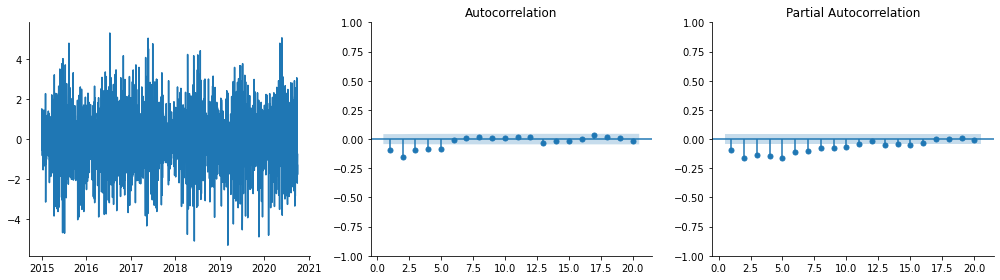

In [20]:
tsplot(train[['tmpc']].diff().dropna(), 20)

We can see from acf that the order of p should be under 5 and pacf that the order of q should be around 10.